# Сгенерировать случайный набор двухмерных событий на неподвижной мишени с углом разлета треков 15°, расстоянием 1 между слоями детектора и точностью определения координаты хита 0.01. В детекторе 7 слоев, в событии 8 треков, в датасете 100 событий.

In [ ]:
!pip install 'git+https://github.com/LAL/trackml-library@master#egg=trackml'

  Cloning https://github.com/LAL/trackml-library (to revision master) to /tmp/pip-install-ujirrrtg/trackml_d945c20d868a4992bbcebc9ead47ddaf
  Running command git clone --filter=blob:none --quiet https://github.com/LAL/trackml-library /tmp/pip-install-ujirrrtg/trackml_d945c20d868a4992bbcebc9ead47ddaf
  Resolved https://github.com/LAL/trackml-library to commit 53a165e15a2c885f54c2bef1bd1ed53db6ed9648
  Preparing metadata (setup.py) ... done
  Created wheel for trackml: filename=trackml-3-py2.py3-none-any.whl size=13500 sha256=55f2a668a09c8f3ec0082bc6dce4cc1b898b3ecb5227e208aff461d2efe901fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-ptnicctf/wheels/ba/5b/12/14ebc487d5056967e435b7709669dbffb633424e6c39d5a827
Successfully built trackml


In [63]:
import numpy as np
from scipy.stats import uniform, norm

SCATTER_ANGLE = 15 * np.pi / 180  # угол разлета треков
HIT_Y_ERROR = 0.01                # точность определения координаты хита
N_LAYERS = 7                      # число слоев в детекторе

angle_dist = uniform(-SCATTER_ANGLE, 2*SCATTER_ANGLE)
detector_z = 1.0 + np.arange(N_LAYERS)
dy_dist = norm(scale=HIT_Y_ERROR)

In [64]:
def gen_track(angle):
  df = pd.DataFrame({
    'z': detector_z
  })
  df['y'] = np.tan(angle) * df.z + dy_dist.rvs(N_LAYERS, rng)
  df.index.rename('layer', inplace=True)
  return df

gen_track(np.pi / 4)

,z,y
layer,,
0,1.0,0.983998
1,2.0,1.982552
2,3.0,2.984249
3,4.0,4.019274
4,5.0,4.997561
5,6.0,6.011819
6,7.0,6.988651


In [65]:
def gen_event(n_tracks):
  df = pd.DataFrame({'track_angle': angle_dist.rvs(n_tracks, rng)})
  df['particle_id'] = df.index
  df = df.groupby('particle_id').apply(lambda row: gen_track(row.track_angle.iloc[0]))
  df['weight'] = 1
  df.reset_index(inplace=True)
  df['hit_id'] = df.index
  return df

gen_event(1)

,particle_id,layer,z,y,weight,hit_id
0,0,0,1.0,-0.069626,1,0
1,0,1,2.0,-0.122206,1,1
2,0,2,3.0,-0.198939,1,2
3,0,3,4.0,-0.255449,1,3
4,0,4,5.0,-0.307141,1,4
5,0,5,6.0,-0.389739,1,5
6,0,6,7.0,-0.443350,1,6


In [66]:
def gen_dataset(n_events, n_tracks):
  result = []
  for event_id in range(n_events):
    event = gen_event(n_tracks)
    event['event_id'] = event_id
    result.append(event)
  return pd.concat(result).reset_index(drop=True)

df = gen_dataset(100, 8)  # 100 событий по 8 треков
df

,particle_id,layer,z,y,weight,hit_id,event_id
0,0,0,1.0,0.003444,1,0,0
1,0,1,2.0,0.032870,1,1,0
2,0,2,3.0,0.039363,1,2,0
3,0,3,4.0,0.075758,1,3,0
4,0,4,5.0,0.091691,1,4,0
...,...,...,...,...,...,...,...
5595,7,2,3.0,0.579488,1,51,99
5596,7,3,4.0,0.787763,1,52,99
5597,7,4,5.0,0.981897,1,53,99
5598,7,5,6.0,1.181884,1,54,99


# Перейти в полярные координаты r, ϕ

<Axes: xlabel='z', ylabel='y'>

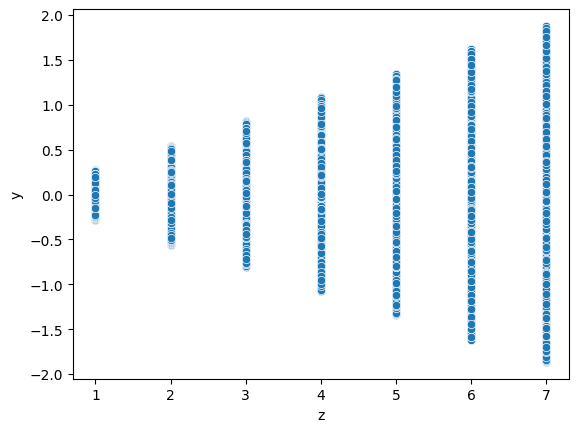

In [67]:
import seaborn as sns
sns.scatterplot(data=df, x='z', y='y')

<Axes: xlabel='z', ylabel='phi'>

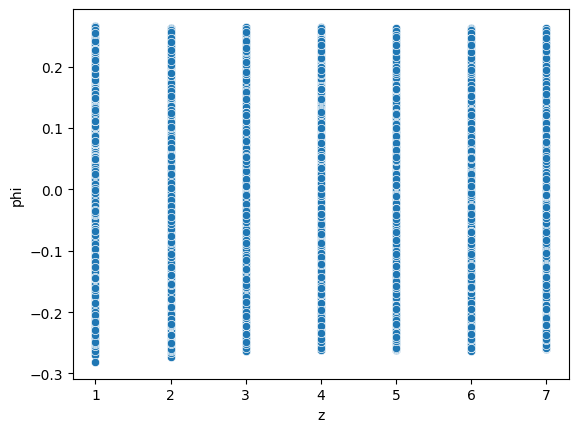

In [68]:
df['r'] = np.sqrt(df.z**2 + df.y**2)
df['phi'] = np.arctan2(df.y, df.z)
sns.scatterplot(data=df, x='z', y='phi')

In [69]:
df.head(10)

,particle_id,layer,z,y,weight,hit_id,event_id,r,phi
0,0,0,1.0,0.003444,1,0,0,1.000006,0.003444
1,0,1,2.0,0.032870,1,1,0,2.000270,0.016433
2,0,2,3.0,0.039363,1,2,0,3.000258,0.013120
3,0,3,4.0,0.075758,1,3,0,4.000717,0.018937
4,0,4,5.0,0.091691,1,4,0,5.000841,0.018336
5,0,5,6.0,0.092795,1,5,0,6.000718,0.015465
6,0,6,7.0,0.126943,1,6,0,7.001151,0.018133
7,1,0,1.0,0.003598,1,7,0,1.000006,0.003598
8,1,1,2.0,0.051456,1,8,0,2.000662,0.025722
9,1,2,3.0,0.070873,1,9,0,3.000837,0.023620


# Провести кластеризацию методом MeanShift (по углу ϕ) для одного события

<Axes: >

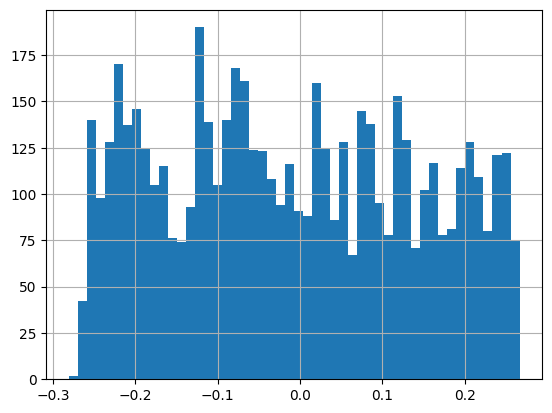

In [107]:
df.phi.hist(bins=50)

In [108]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

track_id = np.array([])  # ndarray кластеров для всего датасета

for i in range(0, 100):  # i - id события
    selected_event = df.loc[df['event_id'] == i]
    x_train = selected_event['phi'].to_numpy()

    # MeanShift чувствителен к масштабу
    # масштабируем данные перед использованием MeanShift
    bandwidth = estimate_bandwidth(x_train.reshape(-1, 1))
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
    ms.fit_predict(x_train.reshape(-1, 1))

    track_id = np.concatenate((track_id, ms.labels_))

In [109]:
df = df.assign(track_id=track_id)
df

,particle_id,layer,z,y,weight,hit_id,event_id,r,phi,track_id
0,0,0,1.0,0.003444,1,0,0,1.000006,0.003444,0.0
1,0,1,2.0,0.032870,1,1,0,2.000270,0.016433,0.0
2,0,2,3.0,0.039363,1,2,0,3.000258,0.013120,0.0
3,0,3,4.0,0.075758,1,3,0,4.000717,0.018937,0.0
4,0,4,5.0,0.091691,1,4,0,5.000841,0.018336,0.0
...,...,...,...,...,...,...,...,...,...,...
5595,7,2,3.0,0.579488,1,51,99,3.055455,0.190813,0.0
5596,7,3,4.0,0.787763,1,52,99,4.076833,0.194452,0.0
5597,7,4,5.0,0.981897,1,53,99,5.095500,0.193912,0.0
5598,7,5,6.0,1.181884,1,54,99,6.115296,0.194491,0.0


In [110]:
df['track_id'].unique()

array([0., 2., 1., 3., 4.])

In [111]:
import random

selected_event = df.loc[df['event_id'] == random.randint(0, 99)]
selected_event

,particle_id,layer,z,y,weight,hit_id,event_id,r,phi,track_id
4200,0,0,1.0,-0.130906,1,0,75,1.008532,-0.130165,0.0
4201,0,1,2.0,-0.257504,1,1,75,2.016509,-0.128048,0.0
4202,0,2,3.0,-0.371393,1,2,75,3.022901,-0.123171,0.0
4203,0,3,4.0,-0.504138,1,3,75,4.031644,-0.125374,0.0
4204,0,4,5.0,-0.644349,1,4,75,5.041348,-0.128164,0.0
4205,0,5,6.0,-0.756183,1,5,75,6.047463,-0.125370,0.0
4206,0,6,7.0,-0.883044,1,6,75,7.055478,-0.125486,0.0
4207,1,0,1.0,0.056236,1,7,75,1.001580,0.056177,1.0
4208,1,1,2.0,0.138616,1,8,75,2.004798,0.069198,1.0
4209,1,2,3.0,0.194256,1,9,75,3.006283,0.064662,1.0


Text(0.5, 0.98, 'Кластеризация MeanShift для одного события')

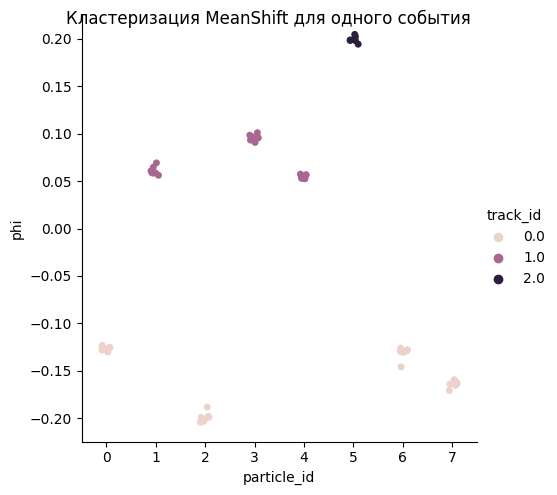

In [112]:
g = sns.catplot(data=selected_event, x='particle_id', y='phi', hue='track_id')
g.fig.suptitle('Кластеризация MeanShift для одного события')

## Получить с помощью trackml_score оценку качества результата трекинга для одного события

In [113]:
from trackml.score import score_event

trackml_score = []

for i in range(0,100):  #  i - id события

    selected_event = df.loc[df['event_id'] == i]

    trackml_score.append(score_event(selected_event, selected_event))

Text(0.5, 1.0, 'Гистограмма распределения trackml_score событий датасета')

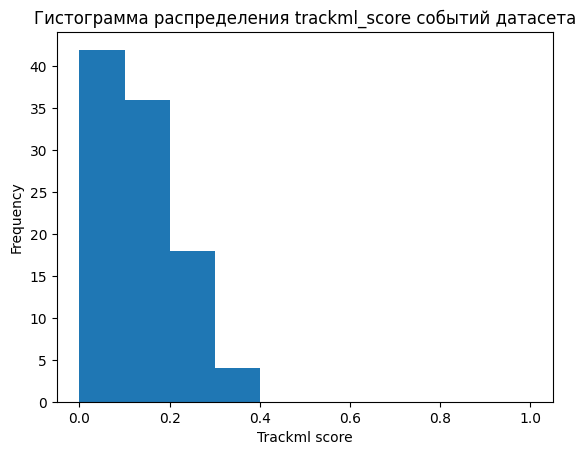

In [114]:
from matplotlib import pyplot as plt

plt.hist(trackml_score, range=(0,1))

plt.xlabel('Trackml score')
plt.ylabel('Frequency')
plt.title('Гистограмма распределения trackml_score событий датасета')

# Провести кластеризацию методом AgglomerativeClustering (по углу ϕ) для одного события

In [120]:
from sklearn.cluster import AgglomerativeClustering

track_id = np.array([])  # ndarray кластеров для всего датасета

ac = AgglomerativeClustering(n_clusters=5, linkage='ward')

for i in range(0,100):  #  i - id события
    selected_event = df.loc[df['event_id'] == i]

    x_train = selected_event['phi'].to_numpy()

    ac.fit_predict(x_train.reshape(-1, 1))

    track_id = np.concatenate((track_id, ac.labels_))

In [121]:
df = df.assign(track_id=track_id)
df

,particle_id,layer,z,y,weight,hit_id,event_id,r,phi,track_id
0,0,0,1.0,0.003444,1,0,0,1.000006,0.003444,4.0
1,0,1,2.0,0.032870,1,1,0,2.000270,0.016433,4.0
2,0,2,3.0,0.039363,1,2,0,3.000258,0.013120,4.0
3,0,3,4.0,0.075758,1,3,0,4.000717,0.018937,4.0
4,0,4,5.0,0.091691,1,4,0,5.000841,0.018336,4.0
...,...,...,...,...,...,...,...,...,...,...
5595,7,2,3.0,0.579488,1,51,99,3.055455,0.190813,0.0
5596,7,3,4.0,0.787763,1,52,99,4.076833,0.194452,0.0
5597,7,4,5.0,0.981897,1,53,99,5.095500,0.193912,0.0
5598,7,5,6.0,1.181884,1,54,99,6.115296,0.194491,0.0


In [122]:
df['track_id'].unique()

array([4., 2., 0., 1., 3.])

In [123]:
import random

selected_event = df.loc[df['event_id'] == random.randint(0, 99)]
selected_event

,particle_id,layer,z,y,weight,hit_id,event_id,r,phi,track_id
1792,0,0,1.0,0.252439,1,0,32,1.031371,0.247273,3.0
1793,0,1,2.0,0.512699,1,1,32,2.064669,0.250946,3.0
1794,0,2,3.0,0.746961,1,2,32,3.091594,0.244025,3.0
1795,0,3,4.0,0.958244,1,3,32,4.113178,0.235130,3.0
1796,0,4,5.0,1.226065,1,4,32,5.148129,0.240468,3.0
1797,0,5,6.0,1.486537,1,5,32,6.181407,0.242866,3.0
1798,0,6,7.0,1.711763,1,6,32,7.206257,0.239831,3.0
1799,1,0,1.0,-0.042932,1,7,32,1.000921,-0.042906,2.0
1800,1,1,2.0,-0.054097,1,8,32,2.000731,-0.027042,2.0
1801,1,2,3.0,-0.077504,1,9,32,3.001001,-0.025829,2.0


Text(0.5, 0.98, 'Кластеризация AgglomerativeClustering для одного события')

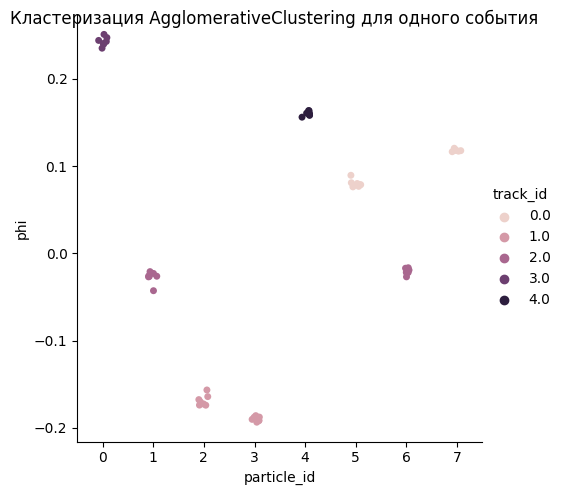

In [124]:
g = sns.catplot(data=selected_event, x='particle_id', y='phi', hue='track_id')
g.fig.suptitle('Кластеризация AgglomerativeClustering для одного события')

# Провести кластеризацию методом KMeans (по углу ϕ) для одного события

In [126]:
from sklearn.cluster import KMeans

track_id = np.array([])  # ndarray кластеров для всего датасета

km = KMeans(n_clusters=5)

for i in range(0,100):  #  i - id события
    selected_event = df.loc[df['event_id'] == i]

    x_train = selected_event['phi'].to_numpy()

    km.fit_predict(x_train.reshape(-1, 1))

    track_id = np.concatenate((track_id, km.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [127]:
df = df.assign(track_id=track_id)
df

,particle_id,layer,z,y,weight,hit_id,event_id,r,phi,track_id
0,0,0,1.0,0.003444,1,0,0,1.000006,0.003444,4.0
1,0,1,2.0,0.032870,1,1,0,2.000270,0.016433,4.0
2,0,2,3.0,0.039363,1,2,0,3.000258,0.013120,4.0
3,0,3,4.0,0.075758,1,3,0,4.000717,0.018937,4.0
4,0,4,5.0,0.091691,1,4,0,5.000841,0.018336,4.0
...,...,...,...,...,...,...,...,...,...,...
5595,7,2,3.0,0.579488,1,51,99,3.055455,0.190813,1.0
5596,7,3,4.0,0.787763,1,52,99,4.076833,0.194452,1.0
5597,7,4,5.0,0.981897,1,53,99,5.095500,0.193912,1.0
5598,7,5,6.0,1.181884,1,54,99,6.115296,0.194491,1.0


In [128]:
df['track_id'].unique()

array([4., 0., 1., 3., 2.])

In [131]:
import random

selected_event = df.loc[df['event_id'] == random.randint(0, 99)]
selected_event

,particle_id,layer,z,y,weight,hit_id,event_id,r,phi,track_id
1456,0,0,1.0,-0.067699,1,0,26,1.002289,-0.067596,4.0
1457,0,1,2.0,-0.125162,1,1,26,2.003913,-0.062499,4.0
1458,0,2,3.0,-0.187972,1,2,26,3.005883,-0.062575,4.0
1459,0,3,4.0,-0.261477,1,3,26,4.008537,-0.065276,4.0
1460,0,4,5.0,-0.327338,1,4,26,5.010704,-0.065374,4.0
1461,0,5,6.0,-0.391389,1,5,26,6.012752,-0.065139,4.0
1462,0,6,7.0,-0.455566,1,6,26,7.014809,-0.064989,4.0
1463,1,0,1.0,-0.014070,1,7,26,1.000099,-0.014069,1.0
1464,1,1,2.0,-0.010871,1,8,26,2.000030,-0.005436,1.0
1465,1,2,3.0,-0.039308,1,9,26,3.000258,-0.013102,1.0


Text(0.5, 0.98, 'Кластеризация KMeans для одного события')

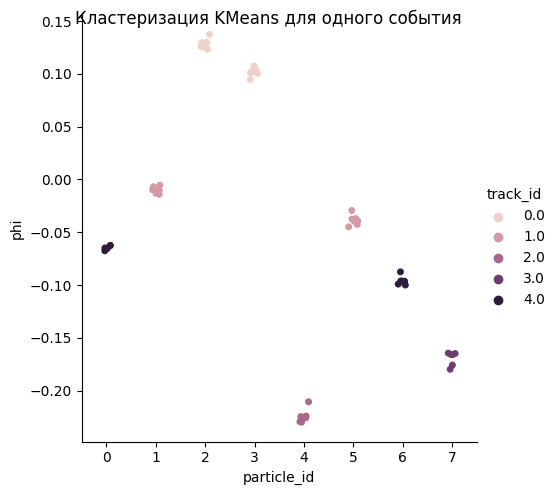

In [132]:
g = sns.catplot(data=selected_event, x='particle_id', y='phi', hue='track_id')
g.fig.suptitle('Кластеризация KMeans для одного события')

# Провести кластеризацию методом AffinityPropagation (по углу ϕ) для одного события смотри тут -> https://github.com/level0rd/Machine-Learning/blob/main/Fourth_year/Colab_notebooks/4_Clustering_tracking.ipynb